# Detailed plots with `tqec`

The `tqec` library provides tools to create detailed plots of the results obtained with `sinter`. Below is an example of the type of plots you can generate with `tqec`. 

![A detailed plot of the memory experiment with d = 3, 5 or 7 and an inset plot for threshold information](./detailed_plot_memory.png)

This notebook will guide you through the process of creating such a plot for a basic memory experiment.

## 1. Create the computation

The first step of any plot is to create the quantum computation that will be used to generate the plots. In our case, this is a memory experiment.

In [1]:
from tqec.gallery.memory import memory
from tqec.utils.enums import Basis

block_graph = memory(Basis.Z)
observables = block_graph.find_correlation_surfaces()

## 2. Perform the simulations 

Then, we need to perform multiple simulation to gather statistics to plot.

This gathering stage is split in 3 parts:

1. Computing general statistics over a large range of physical error-rate (e.g., $p \in [10^{-4}, 10^{-1}]$),
2. Computing an estimate of the threshold $p_\text{thres}$ under which increasing the code distance corrects more errors,
3. Computing fine statistics around the computed threshold.

First, define the parameters of our simulation.

In [2]:
import numpy
import sinter
from tqec.compile.convention import FIXED_BULK_CONVENTION

# Define the values of k (scaling factor) and p (physical error-rate) for which
# we want data points.
ks = list(range(1, 4))
ps = list(numpy.logspace(-4, -1, 10))

# Only use a low number of shots for demonstration purposes.
max_shots = 1_000_000
max_errors = 500

# All the data will be collected observable per observable, let's have
# data-structures to store the results
main_statistics: list[list[sinter.TaskStats]] = []
thresholds: list[float] = []
threshold_statistics: list[list[sinter.TaskStats]] = []

### 2.1. Gathering general statistics

This part should be quite familiar if you already used the `tqec.simulation` module.

In [3]:
from tqec.simulation.simulation import start_simulation_using_sinter
from tqec.utils.noise_model import NoiseModel

for i, obs in enumerate(observables):
    stats = start_simulation_using_sinter(
        block_graph,
        range(1, 4),
        list(numpy.logspace(-4, -1, 10)),
        NoiseModel.uniform_depolarizing,
        manhattan_radius=2,
        convention=FIXED_BULK_CONVENTION,
        observables=[obs],
        max_shots=max_shots,
        max_errors=max_errors,
        decoders=["pymatching"],
        split_observable_stats=False,
    )
    main_statistics.append(stats[0])

### 2.2. Estimating the threshold

The next step will be to have a good-enough estimation of the provided computation threshold. This threshold will help us calibrating the next step where we perform more sampling around the estimated threshold value to have a detailed view of the code behaviour near its threshold.

In [4]:
from math import log10
from tqec.simulation.threshold import binary_search_threshold

for obs in observables:
    threshold, _ = binary_search_threshold(
        block_graph,
        obs,
        NoiseModel.uniform_depolarizing,
        manhattan_radius=2,
        minp=10**-5,
        maxp=0.1,
        convention=FIXED_BULK_CONVENTION,
        max_shots=max_shots,
        max_errors=max_errors,
        decoders=["pymatching"],
    )
    thresholds.append(threshold)

log10_thresholds = [log10(t) for t in thresholds]
mint, maxt = min(log10_thresholds), max(log10_thresholds)
log10_threshold_bounds = (mint - 0.2, maxt + 0.2)

## 2.3. Gathering statistics around the threshold

Now that we have a good estimation of the computation threshold, we can gather statistics around it.

In [5]:
for obs in observables:
    threshold_stats = start_simulation_using_sinter(
        block_graph,
        ks,
        list(numpy.logspace(*log10_threshold_bounds, 20)),
        NoiseModel.uniform_depolarizing,
        manhattan_radius=2,
        convention=FIXED_BULK_CONVENTION,
        observables=[obs],
        num_workers=30,
        max_shots=10_000_000,
        max_errors=5_000,
        decoders=["pymatching"],
        split_observable_stats=False,
    )
    threshold_statistics.append(threshold_stats[0])

## 3. Plot

All the statistics we need should now be computed. Let's plot!

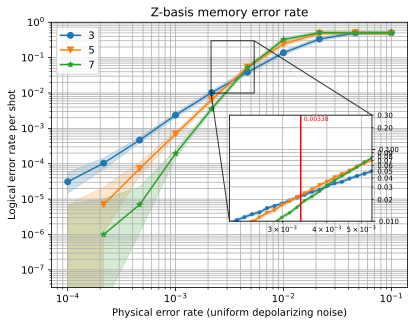

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqec.simulation.plotting.inset import plot_threshold_as_inset

zx_graph = block_graph.to_zx_graph()

for i, obs in enumerate(observables):
    main_stats = main_statistics[i]
    threshold = thresholds[i]
    thres_stats = threshold_statistics[i]

    fig, ax = plt.subplots()
    sinter.plot_error_rate(
        ax=ax,
        stats=main_stats,
        x_func=lambda stat: stat.json_metadata["p"],
        group_func=lambda stat: stat.json_metadata["d"],
    )
    xmin = 10 ** log10_threshold_bounds[0]
    xmax = 10 ** log10_threshold_bounds[1]
    # Note: the below values require prior knowledge about the values to look
    # for on the Y-axis.
    ymin, ymax = 1e-2, 3e-1
    plot_threshold_as_inset(
        ax,
        thres_stats,
        # Note: ymax is **before** ymin because the y axis is inversed.
        zoom_bounds=(xmin, ymax, xmax, ymin),
        threshold=threshold,
        inset_bounds=(0.5, 0.25, 0.4, 0.4),
    )
    ax.grid(which="both", axis="both")
    ax.legend()
    ax.loglog()
    ax.set_title("Z-basis memory error rate")
    ax.set_xlabel("Physical error rate (uniform depolarizing noise)")
    ax.set_ylabel("Logical error rate per shot")
    ax.set_ylim(10**-7.5, 10**0)